# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 30.8 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 72.6 MB/s eta 0:00:01


**Important: Restart the Kernel at this moment**

## Imports

In [15]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [16]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
train = torchvision.datasets.MNIST(root='data', transform=transform, train=True, download=True)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle= True)

# Create test set and define test dataloader
test = torchvision.datasets.MNIST(root='data', transform=transform, train=False, download=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=64)

In [17]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [18]:
images, labels = next(iter(train_dataloader))
images.size()

torch.Size([64, 1, 28, 28])

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**The used Transformer is ToTensor(), to convert all training and testing datasets into tensor to can be used in the whole project.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [19]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


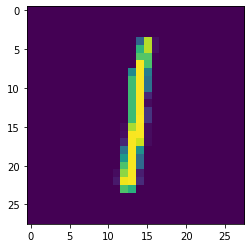

0


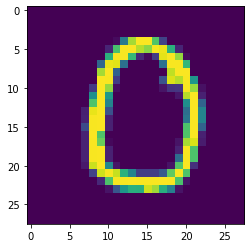

2


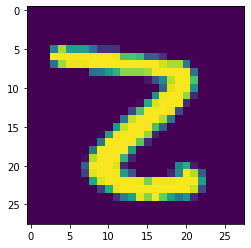

4


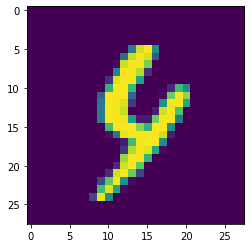

3


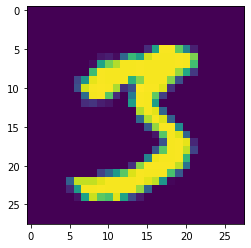

In [20]:
# Explore data
show5(train_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 255)
        self.fc2 = nn.Linear(255, 125)
        self.fc3 = nn.Linear(125, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [28]:
## YOUR CODE HERE ##
criterion = nn.CrossEntropyLoss()

net = Net()
net.to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [36]:
def train_fun():
    num_epochs = 10

    # Establish a list for our history
    train_loss_history = list()
    val_loss_history = list()

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        for i, data in enumerate(train_dataloader):
            # data is a list of [inputs, labels]
            inputs, labels = data

            # Pass to GPU if available.
            if torch.cuda.is_available():
                device = torch.device("cuda:0")
                inputs, labels = inputs.to(device), labels.to(device)

            # Zero out the gradients of the optimizer
            optimizer.zero_grad()

            # Get the outputs of your model and compute your loss
            outputs = net(inputs)
            loss = criterion(outputs, labels)
        
            # Compute the loss gradient using the backward method and have the optimizer take a step
            loss.backward()
            optimizer.step()

            # Compute the accuracy and print the accuracy and loss
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).float().mean().item()
            train_loss += loss.item()
        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_dataloader)*100:.2f}% training loss: {train_loss/len(train_dataloader):.5f}')
        train_loss_history.append(train_loss/len(train_dataloader))

        val_loss = 0.0
        val_correct = 0
        net.eval()
        for inputs, labels in test_dataloader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).float().mean().item()
            val_loss += loss.item()
        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_dataloader)*100:.2f}% validation loss: {val_loss/len(test_dataloader):.5f}')
        val_loss_history.append(val_loss/len(test_dataloader))
        
train_fun()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 training accuracy: 96.27% training loss: 0.12462
Epoch 1 validation accuracy: 96.01% validation loss: 0.13024
Epoch 2 training accuracy: 96.59% training loss: 0.11581
Epoch 2 validation accuracy: 95.71% validation loss: 0.13779
Epoch 3 training accuracy: 96.80% training loss: 0.10854
Epoch 3 validation accuracy: 96.36% validation loss: 0.11697
Epoch 4 training accuracy: 97.01% training loss: 0.10153
Epoch 4 validation accuracy: 96.64% validation loss: 0.10997
Epoch 5 training accuracy: 97.20% training loss: 0.09471
Epoch 5 validation accuracy: 96.68% validation loss: 0.10889
Epoch 6 training accuracy: 97.35% training loss: 0.08925
Epoch 6 validation accuracy: 96.56% validation loss: 0.10772
Epoch 7 training accuracy: 97.47% training loss: 0.08449
Epoch 7 validation accuracy: 96.75% validation loss: 0.10227
Epoch 8 training accuracy: 97.60% training loss: 0.07946
Epoch 8 validation accuracy: 96.75% validation loss: 0.10490
Epoch 9 training accuracy: 97.72% training loss: 0.07547

In [34]:
val_loss_history

[0.3167703905777567,
 0.28209996970880563,
 0.2625325401224623,
 0.22850832942232585,
 0.19378272350284326,
 0.18335268100735488,
 0.1679535702843765,
 0.16412647914995623,
 0.14452947779546735,
 0.1383977902795123]

Plot the training loss (and validation loss/accuracy, if recorded).

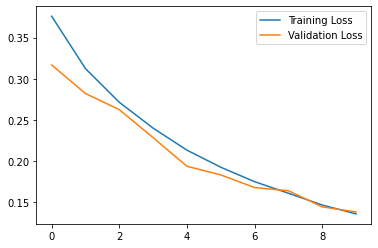

In [31]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [37]:
## Same code as Validation ##
for epoch in range(num_epochs):
    test_loss = 0.0
    test_correct = 0
    net.eval()
    for inputs, labels in test_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to("cuda"), labels.to("cuda")

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).float().mean().item()
        test_loss += loss.item()
    print(f'Epoch {epoch + 1} test accuracy: {val_correct/len(test_dataloader)*100:.2f}% test loss: {test_loss/len(test_dataloader):.5f}')

Epoch 1 test accuracy: 95.90% test loss: 0.09637
Epoch 2 test accuracy: 95.90% test loss: 0.09637
Epoch 3 test accuracy: 95.90% test loss: 0.09637
Epoch 4 test accuracy: 95.90% test loss: 0.09637
Epoch 5 test accuracy: 95.90% test loss: 0.09637
Epoch 6 test accuracy: 95.90% test loss: 0.09637
Epoch 7 test accuracy: 95.90% test loss: 0.09637
Epoch 8 test accuracy: 95.90% test loss: 0.09637
Epoch 9 test accuracy: 95.90% test loss: 0.09637
Epoch 10 test accuracy: 95.90% test loss: 0.09637


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [38]:
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.5)
train_fun()

Epoch 1 training accuracy: 98.22% training loss: 0.06153
Epoch 1 validation accuracy: 97.15% validation loss: 0.09079
Epoch 2 training accuracy: 98.26% training loss: 0.06039
Epoch 2 validation accuracy: 97.23% validation loss: 0.09032
Epoch 3 training accuracy: 98.29% training loss: 0.05972
Epoch 3 validation accuracy: 97.18% validation loss: 0.09052
Epoch 4 training accuracy: 98.31% training loss: 0.05932
Epoch 4 validation accuracy: 97.16% validation loss: 0.08975
Epoch 5 training accuracy: 98.31% training loss: 0.05896
Epoch 5 validation accuracy: 97.14% validation loss: 0.08953
Epoch 6 training accuracy: 98.32% training loss: 0.05856
Epoch 6 validation accuracy: 97.25% validation loss: 0.08935
Epoch 7 training accuracy: 98.33% training loss: 0.05819
Epoch 7 validation accuracy: 97.19% validation loss: 0.08909
Epoch 8 training accuracy: 98.34% training loss: 0.05777
Epoch 8 validation accuracy: 97.27% validation loss: 0.08894
Epoch 9 training accuracy: 98.37% training loss: 0.05737

## Saving your model
Using `torch.save`, save your model for future loading.

In [35]:
torch.save(net, 'net.py')

tensor([0], device='cuda:0')


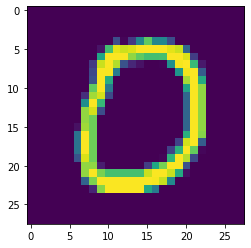

In [76]:
#using the model to predict
imgs, labels = next(iter(test_dataloader))
img = imgs[10]
plt.imshow(img.T.squeeze().T)

img = img.to('cuda')

out = net(img)
_, preds = torch.max(out.data, 1)
print(preds)